# Eyetracking validation

In [7]:
# Setup
import numpy as np
import aopy
import pandas as pd
import os
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import datetime
from db import dbfunctions as db

from IPython.display import display, Markdown

In [15]:
# Get data

today = datetime.date(2022,11,1)

entries = db.get_task_entries('beignet', date=(today))
[print(e.date.date(), e.ui_id) for e in entries];


2022-11-01 flash (7229)
2022-11-01 flash (7231)
2022-11-01 simple center out (delay/go cue) (7232)
2022-11-01 simple center out (delay/go cue) (7233)
2022-11-01 simple center out (delay/go cue) (7234)
2022-11-01 simple center out (delay/go cue) (7235)


In [16]:
entry = entries[-1]
print(entry)
subject, date, te_id = db.get_entry_details(entry)

2022-11-01 14:58:29.480159: beignet on manual control task, id=7235


In [17]:
# Data check 
preproc_dir = '/data/preprocessed.new'
exp_data, exp_metadata = aopy.postproc.load_preproc_exp_data(preproc_dir, subject, te_id, date)
eye_data, eye_metadata = aopy.postproc.load_preproc_eye_data(preproc_dir, subject, te_id, date)


In [18]:
# Parse the raw eye data; this could be extended in the future to support other eyetracking hardware
data_dir = '/data/raw/'
files = exp_metadata['source_files']
eye_data, eye_metadata = aopy.preproc.parse_oculomatic(data_dir, files, debug=True)

use bmi3d supplied eye channel definition [10, 11, 8, 9]


In [19]:
assert 'labels' in eye_metadata

In [26]:
correlation_coeff

array([-0.00081998,  0.10096157, -0.00480388,  0.09736039])

## Calibrating eye data


In [25]:
from aopy.preproc import parse_oculomatic, calc_eye_calibration
eye_data, eye_metadata = parse_oculomatic(data_dir, files, debug=True)
eye_data = eye_data['data']

cursor_samplerate = exp_metadata['cursor_interp_samplerate']
cursor_data = exp_data['cursor_interp']
events = exp_data['events']
event_codes = events['code']
event_times = events['timestamp'] # time points in the ecube time frame
coeff, correlation_coeff, cursor_calibration_data, eye_calibration_data = calc_eye_calibration(
    cursor_data, cursor_samplerate, eye_data, eye_metadata['samplerate'], 
    event_times, event_codes, return_datapoints=True)

use bmi3d supplied eye channel definition [10, 11, 8, 9]


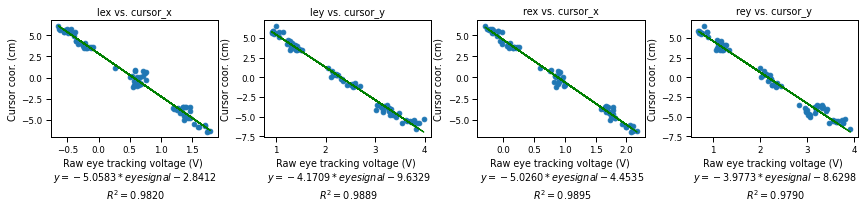

In [26]:
estimated_calibration_pos = aopy.postproc.get_calibrated_eye_data(eye_calibration_data, coeff)

fig, ax = plt.subplots(1,4, figsize=(12,3))
for i in range(4):
    eye_label = ['lex', 'ley', 'rex', 'rey'][i]#eye_metadata['labels'][i].decode('utf-8')
    cursor_label = ['cursor_x', 'cursor_y'][i % 2]

    ax[i].set_title(f'{eye_label} vs. {cursor_label}')
    ax[i].scatter(eye_calibration_data[:,i], cursor_calibration_data[:,i])
    ax[i].plot(eye_calibration_data[:,i], estimated_calibration_pos[:,i], 'g')
    ax[i].set_xlabel(f"Raw eye tracking voltage (V) \n $y = {coeff[i,0]:.4f} *eye signal - {coeff[i,1]:.4f}$ \n $R^2 = {correlation_coeff[i]**2:.4f}$ ")
    ax[i].set_ylabel('Cursor coor. (cm)')
#         ax[i].set(adjustable='box-forced', aspect='equal')

plt.tight_layout()       

    

Text(0.5, 1.0, 'Right eye')

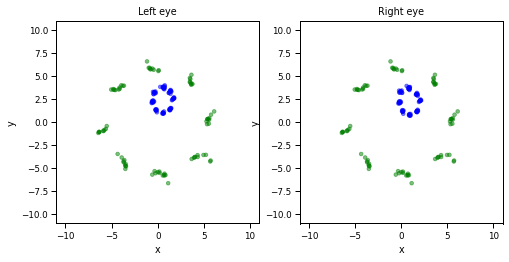

In [27]:
bounds = [-10, 10, -10, 10]
fig, ax = plt.subplots(1, 2, figsize=(8,8))
aopy.visualization.plot_circles(eye_calibration_data[:,[0,1]], 0.2, circle_color='b', bounds=bounds, ax=ax[0])
aopy.visualization.plot_circles(cursor_calibration_data[:,[0,1]], 0.2, circle_color='g', bounds=bounds, ax=ax[0])
ax[0].set_title('Left eye')
aopy.visualization.plot_circles(eye_calibration_data[:,[2,3]], 0.2, circle_color='b', bounds=bounds, ax=ax[1])
aopy.visualization.plot_circles(cursor_calibration_data[:,[0,1]], 0.2, circle_color='g', bounds=bounds, ax=ax[1])
ax[1].set_title('Right eye')
    

In [48]:
from aopy.precondition import downsample
samplerate = 240
eye_data_ds = downsample(eye_data, eye_metadata['samplerate'], samplerate)

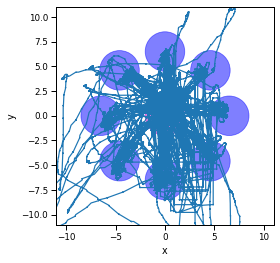

In [49]:
# plot eye trajectories in 2d space over targets
from aopy.postproc import get_target_locations
try:
    targs = range(0,9)
    unique_targets = get_target_locations(preproc_dir, subject, te_id, date, targs)
    aopy.visualization.plot_targets(unique_targets, 2, bounds)
except Exception as e:
    print("Not enough data to plot target locations for all targets:")
    print(e)
    
calibrated_eye_data = aopy.postproc.get_calibrated_eye_data(eye_data, coeff)
aopy.visualization.plot_trajectories([calibrated_eye_data], bounds)

In [47]:
coeff

array([[-5.05825809,  2.841222  ],
       [-4.17092289,  9.63294902],
       [-5.02604766,  4.4535021 ],
       [-3.97730409,  8.62984309]])

## Plotting calibrated data

In [52]:
trial_start_codes = exp_metadata['event_sync_dict']['TARGET_ON'] # center target
trial_end_codes = exp_metadata['event_sync_dict']['TRIAL_END']

Text(0.5, 0, 'time (ms)')

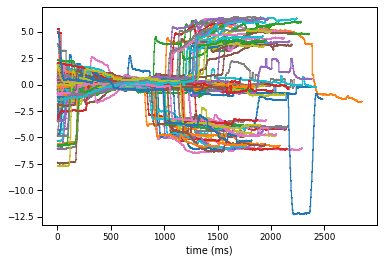

In [53]:
# Try getting segments from the preprocessed file
eye, segments = aopy.postproc.get_kinematic_segments(preproc_dir, subject, te_id, date, 
                                                      trial_start_codes, trial_end_codes,
                                                      datatype='eye')

for t in eye:
    time = 1000*np.arange(len(t[:,0]))/eye_metadata['samplerate'] # in ms
    plt.plot(time, t[:,0])
plt.xlabel('time (ms)')

Text(0, 0.5, 'dist from center (cm)')

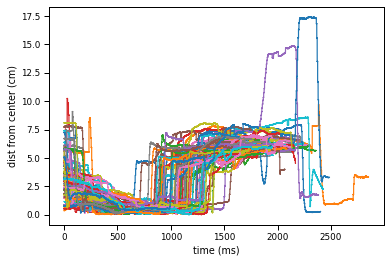

In [54]:
for t in eye:
    time = 1000*np.arange(len(t[:,0]))/eye_metadata['samplerate'] # in ms
    plt.plot(time, np.sqrt(t[:,0]**2 + t[:,1]**2))
plt.xlabel('time (ms)')
plt.ylabel('dist from center (cm)')

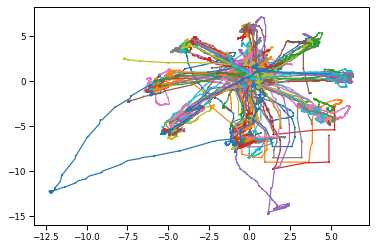

In [55]:
for t in eye:
    plt.plot(t[:,0], t[:,1])
